# Counterfactual explanations for the GSMarena dataset

## Installations and imports

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [1]:
# !mkdir my_repo
# !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo

Cloning into 'my_repo'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 254 (delta 122), reused 199 (delta 67), pack-reused 0
Receiving objects: 100% (254/254), 7.77 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [2]:
# %cd my_repo

/content/my_repo


In [3]:
# !pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 2.5 MB/s eta 0:00:00


### Import of the libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from utils import util_data

import gdown

kaggle.json not found, you cannot use kaggle module.


## Load the dataset

Laod the processed dataset from the repository.

In [40]:
df = pd.read_csv("data/processed/gsm.csv")
df.head(3)

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,40.000000,2020.0,6.10,0,1,0,1,0,0,4G,...,0,0,720.0,1560.0,32.0,3.0,13.0,2.0,5.0,1.0
1,54.509242,2020.0,5.00,0,1,0,1,0,0,3G,...,0,0,720.0,1280.0,8.0,1.0,8.0,1.0,5.0,1.0
2,60.000000,2020.0,5.45,0,1,0,1,0,0,4G,...,0,0,720.0,1440.0,16.0,2.0,8.0,2.0,5.0,1.0


The dataset doesn't contain duplicates, and it is already preprocessed.

In [41]:
X_feat = list(set(df.columns) - set(["misc_price", "launch_announced"]))
# Show duplicated rows
df[df.duplicated(subset=X_feat, keep=False)]

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera


In [42]:
# Keep only the smartphones that are sold starting from 2015
# df = df[df['launch_announced'] >= 2015].drop('launch_announced', axis=1)
# df = df.drop_duplicates().reset_index(drop=True)
df = df.drop("launch_announced", axis=1)

The dataset doesn't contain null values. The total number of rows is 2205.

In [43]:
print(f"Null values:{df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")
print(f"Number of rows: {df.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 2205


### Data transformation for the model

We only need to create the one-hot encoding for the "network_technology" feature because the others have already been binarized from the preprocessing pipeline. Then we should also standardize the continuous features to have the values in the same range. 

In order to make the entire process more structured we will use a pipeline to finish the data preprocessing.

In [44]:
#@title Function for pipeline (TODO: move to utils?)
#@markdown The 'ohe_named' function simply apply the one hot encoding on the selected
#@markdown subset of features and returns a new df with named columns.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

def ohe_named(df):
    '''
        It takes as input a dataframe and it returns a new dataframe with the 
        selected columns one hot encoded.
    '''
    ohe_encoder = {}
    for col in df.columns:
        ohe_encoder[col] = OneHotEncoder(sparse_output=False)
        # Get ohe data and column names
        ohe_data = ohe_encoder[col].fit_transform(df[col].values.reshape(-1, 1))
        new_names = ohe_encoder[col].get_feature_names_out([col])
        # Concat to the original df
        ohe_df = pd.DataFrame(ohe_data, columns=new_names)

        df = pd.concat([df, ohe_df], axis=1).drop(col, axis=1)

    return df

In [45]:
NamedOhe = FunctionTransformer(ohe_named)#, kw_args={"col":"network_technology"})

ohe_feat = ["network_technology"]
num_cols = ["display_size", "battery", "display_width", "display_height", "memory_rom_gb",
            "memory_ram_gb", "main_camera_resolution", "selfie_camera_resolution"]

In [46]:
FeatTransformer = ColumnTransformer(
    transformers=[('ohe_encoder', NamedOhe, ohe_feat), ('num_standardizer', StandardScaler(), num_cols)],
    remainder='passthrough', verbose_feature_names_out=False)

# To have as ouput a dataframe after the transform
FeatTransformer.set_output(transform="pandas");

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


The transformation process is now as follows.

In [ ]:
FeatTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe_encoder',
                                 FunctionTransformer(func=<function ohe_named at 0x0000011F6605E040>),
                                 ['network_technology']),
                                ('num_standardizer', StandardScaler(),
                                 ['display_size', 'battery', 'display_width',
                                  'display_height', 'memory_rom_gb',
                                  'memory_ram_gb', 'main_camera_resolution',
                                  'selfie_camera_resolution'])],
                  verbose_feature_names_out=False)

We apply the transformation calling the method on the dataframe and the preprocessing of the columns is done.

The network_technology column is transformed into a one-hot encoding, describing the maximum the network technology of the device (3G, 4G, 5G).

In [47]:
df = FeatTransformer.fit_transform(df)
df.head()

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera
0,0.0,1.0,0.0,0.766910,0.934759,-0.728877,-0.304942,-0.274219,-0.109769,-0.233003,...,0,1,0,1,0,0,0,0,2.0,1.0
1,1.0,0.0,0.0,-0.826522,-1.345629,-0.728877,-0.843553,-0.710581,-0.733411,-0.607715,...,0,1,0,1,0,0,0,0,1.0,1.0
2,0.0,1.0,0.0,-0.174663,-0.205435,-0.728877,-0.535775,-0.565127,-0.421590,-0.607715,...,0,1,0,1,0,0,0,0,2.0,1.0
3,0.0,1.0,0.0,-0.102235,-0.205435,-0.728877,-0.535775,-0.565127,-0.421590,-0.233003,...,0,1,0,1,0,0,0,0,1.0,1.0
4,0.0,1.0,0.0,0.201966,0.022604,-0.728877,-0.381887,-0.274219,-0.421590,-0.233003,...,0,1,0,1,0,0,0,0,2.0,1.0


In [48]:
std_transf = FeatTransformer.named_transformers_['num_standardizer']

The price distribution is right-skewed: the 50% of the devices have a price between 150 and 310 dollars, while the maximum price is 1000 dollars (capped in the preprocessing step).

In [ ]:
df.misc_price.describe()

count    2205.000000
mean      267.677965
std       174.290393
min        40.000000
25%       150.000000
50%       220.000000
75%       310.000000
max      1000.000000
Name: misc_price, dtype: float64

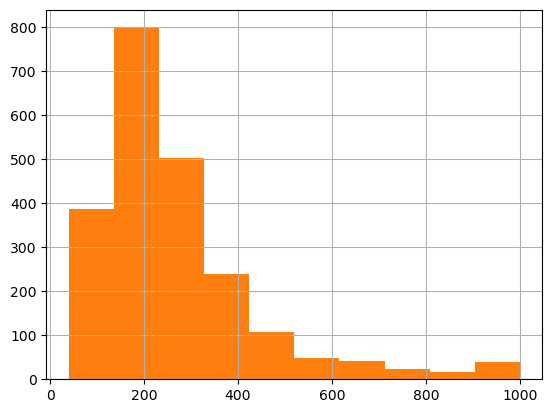

In [ ]:
df.misc_price.hist(bins=10)
plt.show()

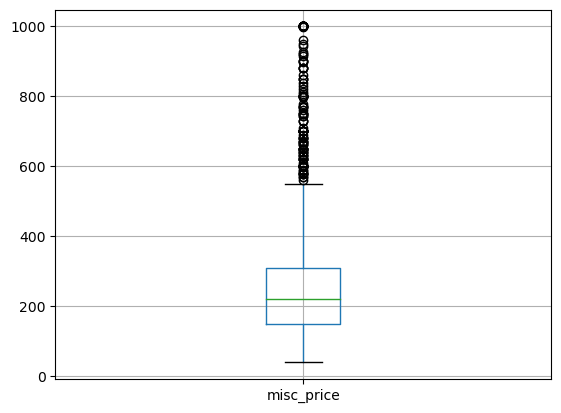

In [ ]:
df.boxplot(column=["misc_price"])
plt.show()

Given that we want to consider a classification problem we need to create bins for the different ranges of price, to split the data in a clever way we decided to consider the quantile and to compute the bounds with statistics.

Apply log transformation to the target variable

In [49]:
# apply log transformation
df["misc_price"] = np.log(df["misc_price"])

In [50]:
q1 = df.misc_price.quantile(0.25)
q3 = df.misc_price.quantile(0.75)
# Take inter-quartile range
iqr = q3 - q1
# lower whiskers as 1.5 smaller than iqr
lower_bound = max(df.misc_price.min(), q1 - iqr * 1.5)
# upper whiskers as 1.5 greater than iqr
upper_bound = min(df.misc_price.max(), q3 + iqr * 1.5)

print(f"lower_bound: {lower_bound}, upper_bound: {upper_bound}")

lower_bound: 3.9217297890218505, upper_bound: 6.825477802553597


In [51]:
df_iqr = df[df.misc_price.between(lower_bound, upper_bound, inclusive="both")]

print(f"Shape before: {df.shape}, shape after: {df_iqr.shape}")

Shape before: (2205, 22), shape after: (2165, 22)


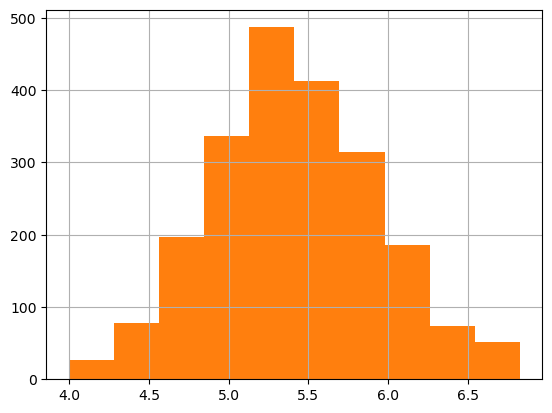

In [ ]:
df_iqr.misc_price.hist(bins=10)
plt.show()

We set four different labels that are representative of the price range of the different devices and we compute the bounds between the different price ranges.

In [52]:
target_labels = ["low", "low-medium", "medium", "high"]
_, bins = pd.cut(df_iqr.misc_price, bins=len(target_labels), retbins=True, labels=target_labels)
# _, bins = pd.qcut(df_iqr.misc_price, q=len(labels), retbins=True, labels=labels)

print(f"Bins: {bins}")

Bins: [3.99554427 4.70487112 5.41137197 6.11787282 6.82437367]


In [ ]:
for i,j in zip(bins[:-1], bins[1:]):
    print(f"[{np.exp(i)}, {np.exp(j)})")

[54.355416327589445, 110.48404471848387)
[110.48404471848387, 223.93861390793234)
[223.93861390793234, 453.8981436349988)
[453.8981436349988, 920.0000000000003)


In [53]:
bins[0] = df.misc_price.min()
bins[-1] = df.misc_price.max()
lab_cat = pd.Series(index=df.index, dtype="object")

for lab, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Range {target_labels[lab]}: {l:.2f} - {u:.2f}")

    idx = df.misc_price.between(l, u, inclusive="both")
    lab_cat.loc[idx] = lab

Range low: 3.69 - 4.70
Range low-medium: 4.70 - 5.41
Range medium: 5.41 - 6.12
Range high: 6.12 - 6.91


In [54]:
# Replace misc_price column with lab_cat
df["misc_price"] = lab_cat
df["misc_price"]

0       0
1       0
2       0
3       0
4       0
       ..
2200    2
2201    2
2202    2
2203    2
2204    2
Name: misc_price, Length: 2205, dtype: object

In [ ]:
util_data.count_frequency_labels(df.misc_price).sort_index()

,Frequency,Count
0,10.02%,221
1,41.13%,907
2,38.64%,852
3,10.20%,225


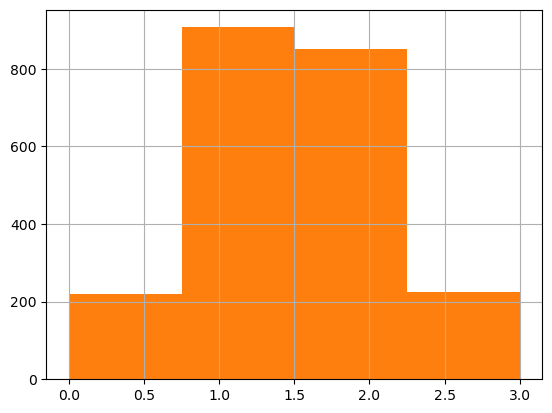

In [ ]:
df.misc_price.hist(bins=4)
plt.show()

As you can see from the previous table the dataset is imbalanced and we need to weigh the samples differently during training.

After the quantization of the price we also have to check whether some samples are now duplicated. Fortunately, it doesn't seem to be the case.

In [55]:
X_feat = list(set(df.columns) - set(["misc_price"]))
df[df.duplicated(subset=X_feat, keep="first")].sort_values(by=df.columns.to_list())

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera


In [56]:
# Remove duplicates and cast types to "float"
# df = df.drop_duplicates().reset_index(drop=True)
df = df.astype({col: "float" for col in df.columns.tolist()})

### Data correlation

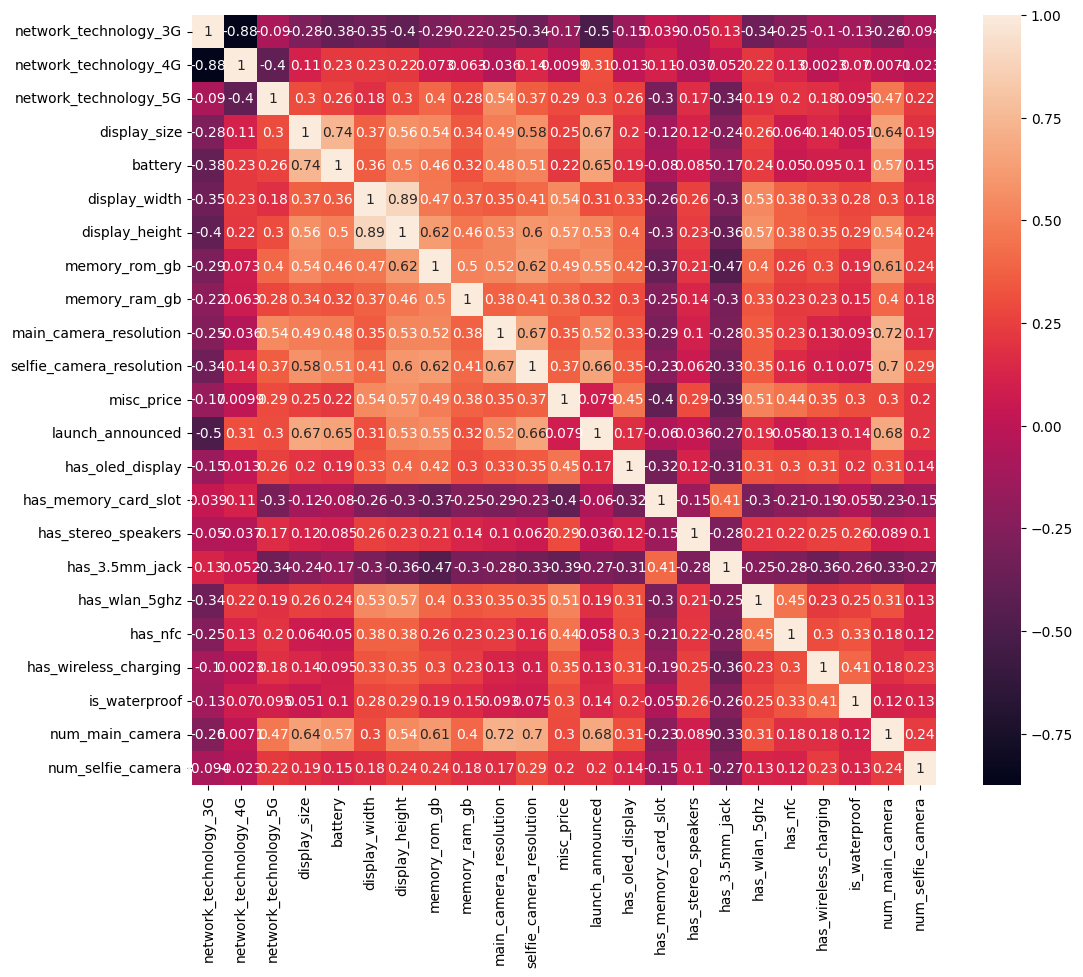

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

TODO: try to remove highly correlated features.

### Train test split for the model

In [57]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["misc_price"]), df.misc_price, test_size=0.15, random_state=42)

In [ ]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1874, 22), X_test: (331, 22), y_train: (1874,), y_test: (331,)


In [58]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (1499, 21), X_val: (375, 21), y_train: (1499,), y_val: (375,)


## Models

We want to test different models on our dataset, starting from the simplest ones and then trying with more complex models such as LightGBM. 

The dataset is small, therefore we believe that simpler models can perform quite well on the test set without incurring in overfitting.

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
dec_tree = DecisionTreeClassifier(random_state=42)

dec_tree = dec_tree.fit(X_train, y_train)

In [ ]:
print(f"The accuracy of the DT on the training set is: {dec_tree.score(X_train, y_train)*100:.2f}%")
print(f"The accuracy of the DT on the test set is: {dec_tree.score(X_test, y_test)*100:.2f}%")

The accuracy of the DT on the training set is: 98.58%
The accuracy of the DT on the test set is: 56.41%


As you can see, there are a lot of overfitting, there are two different methods to deal with it, the pre-pruning and the post-pruning.

#### Pre-pruning
It's the early stopping of the growth of the decision tree, the main hyperparameters to tune are: ```max_depth```, ```min_samples_leaf``` and ```min_samples_split```. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10, 20],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_train)
classes = np.unique(y_train)

# Binarize ytest with shape (n_samples, n_classes)
y_train_pred = label_binarize(grid_cv.predict(X_train), classes=classes)
y_test_pred = label_binarize(grid_cv.predict(X_test), classes=classes)
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, y_train_pred, average="macro", multi_class="ovr"))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, y_test_pred, average="macro", multi_class="ovr"))

Param for GS {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS nan
Train AUC ROC Score for GS:  0.7089079911696565
Test AUC ROC Score for GS:  0.6926962958488884


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


#### Post-pruning
The Post-pruning technique allows the decision tree model to grow to its full depth, then removes the tree branches to prevent the model from overfitting.
In this case we'll try cost complexity pruning.

In [ ]:
path = dec_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

classes = np.unique(y_train)

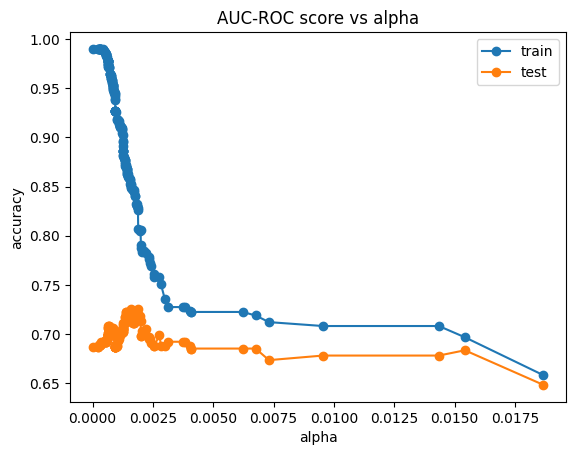

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_train, label_binarize(clf.predict(X_train), classes=classes),
                              multi_class="ovr") for clf in clfs]
test_scores = [roc_auc_score(y_test, label_binarize(clf.predict(X_test), classes=classes),
                             multi_class="ovr") for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

At this point we take the alpha that allows us to have the best accuracy on the test set.

In [ ]:
best_ind_test = np.argmax(test_scores)
best_test_alpha = ccp_alphas[best_ind_test]
print(best_test_alpha)

0.0015840498145398337


Initialize a decision tree using the found alpha to test the accuracy the model is able to obtain.

In [ ]:
dec_tree_best = DecisionTreeClassifier(random_state=42, ccp_alpha=best_test_alpha)

dec_tree_best = dec_tree.fit(X_train, y_train)

In [ ]:
print(f"The accuracy obtained on the training set with the best DT is {dec_tree_best.score(X_train, y_train)*100:.2f}")
print(f"The accuracy obtained on the test set with the best DT is {dec_tree_best.score(X_test, y_test)*100:.2f}")

The accuracy obtained on the training set with the best DT is 78.98
The accuracy obtained on the test set with the best DT is 64.96


We can also check the variation of the depth and the number of nodes of the tree changing the value of alpha.

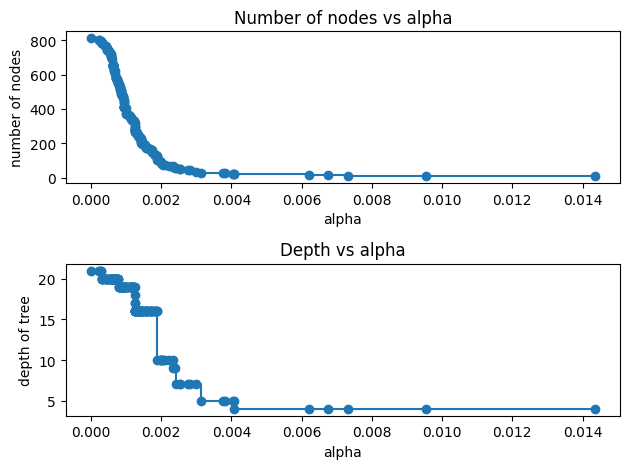

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Random Forest (WIP)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

We have an imbalanced dataset therefore we need to compute weights for the different classes.

In [ ]:
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
dict_weights = {i: w for i, w in enumerate(weights)}
dict_weights

{0: 0.7272727272727273, 1: 0.6583541147132169, 2: 1.6, 3: 2.078740157480315}

In [ ]:
rnd_forest = RandomForestClassifier(n_estimators=500, min_samples_split=10, 
                                    class_weight=dict_weights, random_state=42)

rnd_forest = rnd_forest.fit(X_train, y_train)

In [ ]:
print(f"Accuracy on training set: {rnd_forest.score(X_train, y_train)*100:.2f}%")
print(f"Accuracy on test set: {rnd_forest.score(X_test, y_test)*100:.2f}%")

Accuracy on training set: 85.13%
Accuracy on test set: 63.68%


TODO: why the accuracy gets worse if we consider the weights for the dataset?

### LightGBM model

One of the main drawbacks of this model is that it can overfit with small datasets.

In [ ]:
import lightgbm as lgb
import warnings

from utils.util_models import LightGBM 

With the following parameters we can limit overfitting but the model accuracy on the training set will drop.

TODO: try to set the weights for the different features.

In [ ]:
lgb_params = {"learning_rate": 0.05, "num_iterations":1000, "early_stopping_round":50, 
              "max_bin": 30, "num_leaves": 30, "lambda_l1": 0.3, "random_state":42,
              "force_row_wise":True, "objective":"multiclass", "metric":['multi_error', 'multi_logloss'],
              "num_class": 4}

# Create the data object to give as input to the model
# train_data = lgb.Dataset(X_train, label=y_train, params={'verbose': -1}, free_raw_data=False)
# val_data = lgb.Dataset(X_val, label=y_val, params={'verbose': -1}, free_raw_data=False)

First of all let's create the model that uses the scikit learn api in order to test it on the dataset and to plot some information. 

In [ ]:
lgb_model = LightGBM(parameters=lgb_params, train_data=(X_train, y_train), 
                     val_data=(X_val, y_val))

In [ ]:
# Train the model without verbose output
lgb_model.train_model()

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3


We can plot the metrics considered during the training for the training and the validation dataset to check if there is some overfitting.

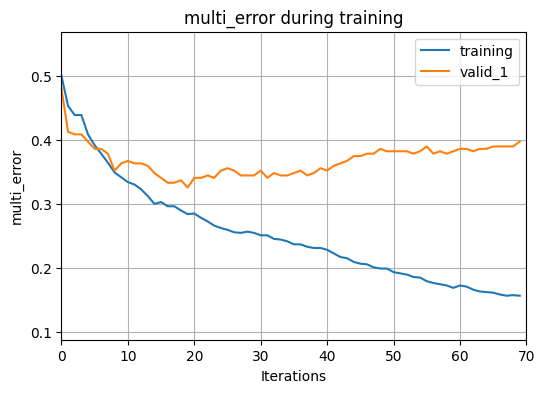

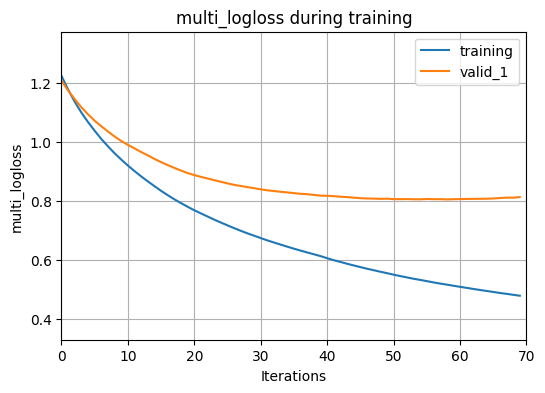

In [ ]:
lgb_model.plot_metrics(figsize=(6,4))

In [ ]:
print(f"The model has an accuracy of {lgb_model.compute_score(accuracy_score, X_train, y_train)*100:.2f}% on the training set.")
print(f"The model has an accuracy of {lgb_model.compute_score(accuracy_score, X_test, y_test)*100:.2f}% on the test set.")

The model has an accuracy of 71.59% on the training set.
The model has an accuracy of 64.10% on the test set.


We can also plot the importance of the different features, computed by the model.

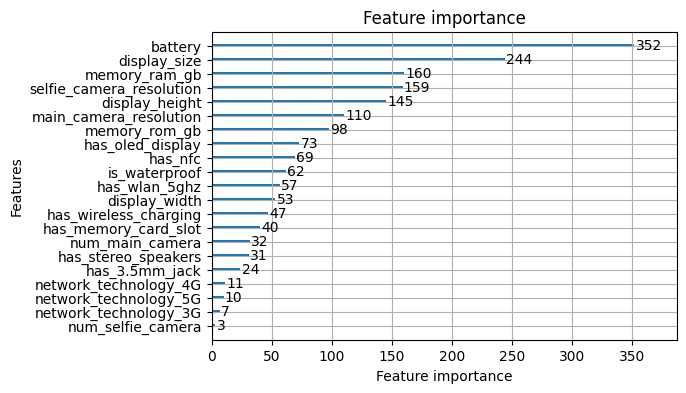

In [ ]:
lgb_model.plot_info(kind="importance", figsize=(6,4))

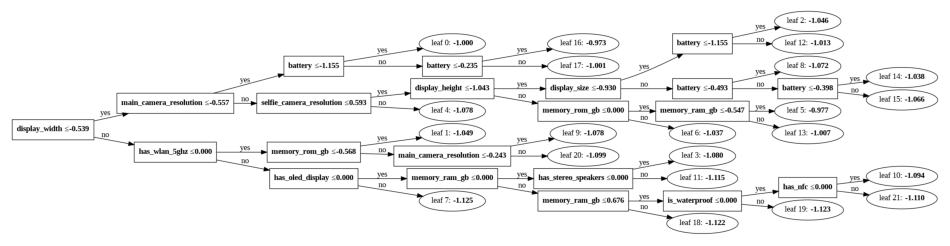

In [ ]:
lgb_model.plot_info(kind="tree", figsize=(12,8))

### Neural network

In [19]:
import torch
from torch.utils.data import DataLoader
import torchsummary

import math

from utils import util_models 
from utils import util_plot 

In [59]:
EPOCHS = 100
BATCH_SIZE = 64
LR = 0.001
N_SPLITS = 5
SEED = 42

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
num_features = X_train.shape[1]
hidden_layers = [64, 64]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=4).to(device)
torchsummary.summary(nn_model, (BATCH_SIZE, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 64, 64]              1,408
├─ReLU: 1-2                              [-1, 64, 64]              --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 64, 64]              4,160
├─ReLU: 1-3                              [-1, 64, 64]              --
├─Linear: 1-4                            [-1, 64, 4]               260
Total params: 5,828
Trainable params: 5,828
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.02
Estimated Total Size (MB): 0.09


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 64, 64]              1,408
├─ReLU: 1-2                              [-1, 64, 64]              --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 64, 64]              4,160
├─ReLU: 1-3                              [-1, 64, 64]              --
├─Linear: 1-4                            [-1, 64, 4]               260
Total params: 5,828
Trainable params: 5,828
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.02
Estimated Total Size (MB): 0.09

In [61]:
train_data = util_models.TrainData(X_train.values, y_train.values)
val_data = util_models.TrainData(X_val.values, y_val.values)
test_data = util_models.TestData(X_test.values)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#### Holdout

In [62]:
losses, accuracies = util_models.train_model(train_loader, val_loader, nn_model, device, LR, 100, print_every=10)

Epoch 010: | Loss: 0.77978 | Acc: 67.111 | Val loss: 0.83737 | Acc: 63.200
Epoch 020: | Loss: 0.74438 | Acc: 67.512 | Val loss: 0.82528 | Acc: 65.067
Epoch 030: | Loss: 0.70275 | Acc: 69.246 | Val loss: 0.81009 | Acc: 63.733
Epoch 040: | Loss: 0.67494 | Acc: 70.247 | Val loss: 0.80294 | Acc: 63.733
Epoch 050: | Loss: 0.64927 | Acc: 70.914 | Val loss: 0.83434 | Acc: 64.800
Epoch 060: | Loss: 0.63185 | Acc: 71.714 | Val loss: 0.82099 | Acc: 65.067
Epoch 070: | Loss: 0.61099 | Acc: 73.115 | Val loss: 0.82220 | Acc: 65.600
Epoch 080: | Loss: 0.59313 | Acc: 73.716 | Val loss: 0.84528 | Acc: 63.467
Epoch 090: | Loss: 0.57343 | Acc: 74.983 | Val loss: 0.84706 | Acc: 63.200
Epoch 100: | Loss: 0.55246 | Acc: 75.984 | Val loss: 0.87210 | Acc: 62.400


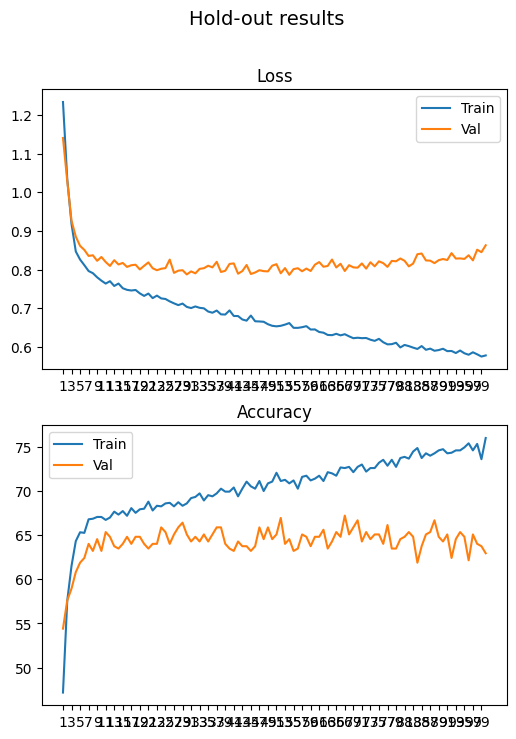

In [ ]:
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")

fig.show()

In [63]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


y_preds = util_models.test_model(test_loader, nn_model, device)
accuracy = evaluate_predictions(y_test, y_preds)
print(f"Accuracy on test: {accuracy}")

Accuracy on test: 65.25679758308156


#### K-FOLD

In [ ]:
EPOCHS = 100
n_losses, n_accuracies = util_models.kfold_train_model(X_train.values, y_train.values,
                                                       N_SPLITS,SEED, BATCH_SIZE, model,
                                                       device, LR, EPOCHS, print_every=10)

Epoch 010: | Loss: 0.87094 | Acc: 62.559 | Val loss: 0.92894 | Acc: 63.679
Epoch 020: | Loss: 0.79424 | Acc: 63.152 | Val loss: 0.88354 | Acc: 65.094
Epoch 030: | Loss: 0.76018 | Acc: 64.573 | Val loss: 0.88136 | Acc: 65.566
Epoch 040: | Loss: 0.73762 | Acc: 65.403 | Val loss: 0.88934 | Acc: 66.038
Epoch 050: | Loss: 0.75454 | Acc: 66.114 | Val loss: 0.88793 | Acc: 67.453
Epoch 060: | Loss: 0.72225 | Acc: 66.825 | Val loss: 0.89395 | Acc: 67.453
Epoch 070: | Loss: 0.73049 | Acc: 67.654 | Val loss: 0.89872 | Acc: 67.925
Epoch 080: | Loss: 0.70267 | Acc: 67.654 | Val loss: 0.89692 | Acc: 66.509
Epoch 090: | Loss: 0.69092 | Acc: 68.483 | Val loss: 0.90354 | Acc: 66.038
Epoch 100: | Loss: 0.67683 | Acc: 67.773 | Val loss: 0.89978 | Acc: 66.509
kfold on group 1 accuracy:  66.51

Epoch 010: | Loss: 0.86666 | Acc: 63.787 | Val loss: 0.90096 | Acc: 58.768
Epoch 020: | Loss: 0.78849 | Acc: 65.917 | Val loss: 0.84664 | Acc: 59.242
Epoch 030: | Loss: 0.75242 | Acc: 67.219 | Val loss: 0.83194 | Ac

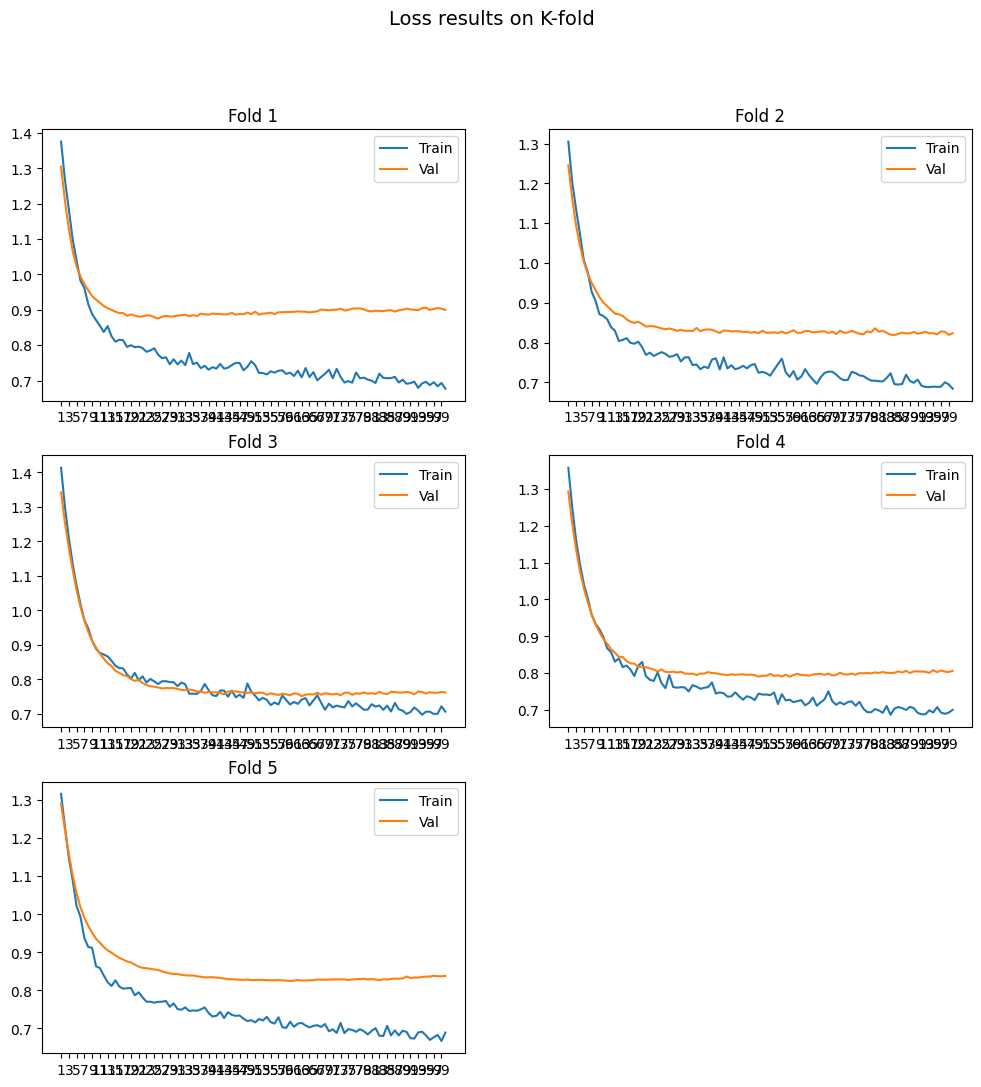

In [ ]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.show()

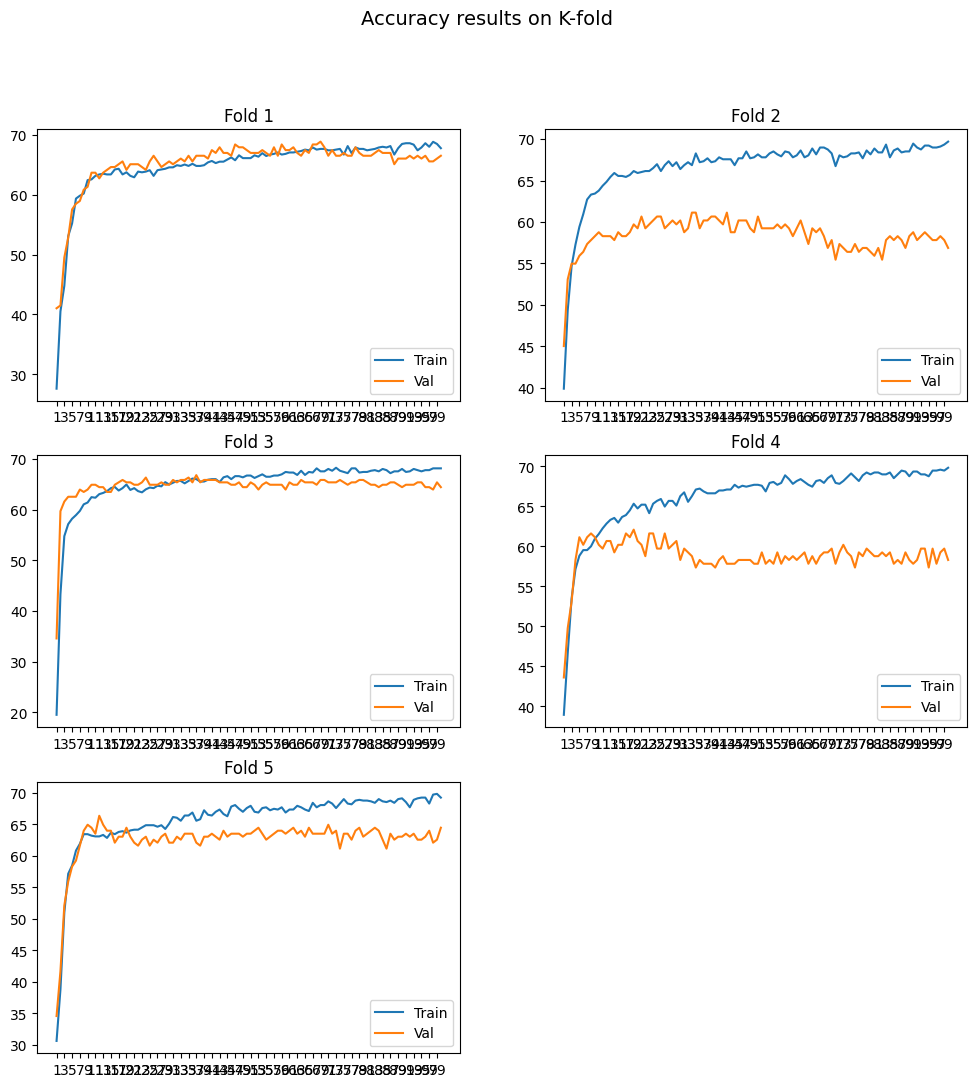

In [ ]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.show()

## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

### OMLT

In [64]:
import tempfile

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

import onnx

We need to declare the bounds for the variables that we are considering.

In [65]:
x_test_np = X_test.values
y_test_np = y_test.values

In [66]:
idx = 3
sample_idx = x_test_np[idx]
label_idx = y_test_np[idx]

#define dummy input tensor    
dummy_sample = torch.tensor(x_test_np[idx].reshape((1, -1))).type(torch.float)

# Define input region defined by infinity norm
# epsilon_infty = 5e-1
lb = np.repeat(-1, len(sample_idx))
# lb = np.maximum(-1, sample_idx - epsilon_infty)
ub = np.repeat(1, len(sample_idx))
# ub = np.minimum(1, sample_idx + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(x_test_np.shape[1]):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

In [ ]:
print(f"Label of sample {idx} is: {label_idx}")

Label of sample 3 is: 3.0


We also export the torch model to an onnx model using the relative function, then we build the formulation of the model that will be used by OMLT to create the optimization model.

In [67]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    # Export neural network to ONNX
    torch.onnx.export(
        nn_model,
        dummy_sample,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    # Write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    # Load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [68]:
formulation = FullSpaceNNFormulation(network_definition)

We can now encode the neural network in a Pyomo model.

In [85]:
# Create pyomo model
pyo_model = pyo.ConcreteModel()

# Create an OMLT block for the neural network and build its formulation
pyo_model.nn = OmltBlock()
pyo_model.nn.build_formulation(formulation) 

Define the objective expression to optimize.

ATTENTION: if you run twice the cell an error will be raised because we overwrite the block, hence you need to run again the cell in which we create the model before to apply changes.

In [ ]:
#@title #### Compute the mean probability for the correctly predicted samples
#@markdown Since in the objective function we need to take a range of probabilities for computing
#@markdown the error (and we consider only correctly predicted samples for the counterfactual generation),
#@markdown we compute the mean and minimum value of the probabilities of the correct class.   
def count_correct_pred(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        correct_prob = []
        for ind in range(X_test.shape[0]):
            sample = torch.tensor(X_test.iloc[ind].tolist(), dtype=torch.float).view(1, -1)
            prob_pred = torch.softmax(model(sample), dim=1)

            max_prob = torch.argmax(prob_pred).item()
            if max_prob == y_test.values[ind]:
                correct_prob.append(prob_pred[0, max_prob])
    return torch.tensor(correct_prob)


correct_probs = count_correct_pred(nn_model, X_test, y_test)
print(f"The minimum probability for a correctly predicted sample is {torch.min(correct_probs):.3f}")
print(f"The mean probability for the correctly predicted samples is {torch.mean(correct_probs):.3f}")

The minimum probability for a correctly predicted sample is 0.385
The mean probability for the correctly predicted samples is 0.743


We looked for a multi-objective function and we found this interesting [paper](https://arxiv.org/pdf/2004.11165.pdf) in which the authors proposed different objectives to optimize.

TODO: check the upper bound we set, because 20 may be wrong given that we use the square difference instead of absolute value of the difference.

In [84]:
#@title #### Functions to create objectives
def my_softmax(input, n_class, real_class):
    '''
        It returns the probability of the desired class after having computed the
        softmax for the input array.
    '''
    exps = [pyo.exp(input[i]) for i in range(n_class)]
    probs = []
    for exp in exps:
        res = exp/sum(exps)
        probs.append(res)
    return probs[real_class]


def create_cat_constraints_obj_2(pyo_model, bounds, idx_cat, sample, feat_network):
    '''
        It creates the sum value for the categorical features of the second 
        objective function.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple(int)
                The lower and upper value for the constraints.
            - idx_cat: list[int]
                The indexes of the categorical features that we need to compare.
            - sample: np.ndarray
                The values for the categorical features of the original sample 
                for which the counterfactual is generated.
            - feat_network: list[int]
                The indexes of the connectivity features for which we need to add
                exclusive or constraints.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, len(idx_cat)))

    pyo_model.b_o2 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o2 = pyo.Var(feat_set, domain=pyo.Integers)
    pyo_model.constr_less_o2 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o2 = pyo.Constraint(feat_set)

    # Limit ohe features (network_connectivity)
    pyo_model.xor_conn = pyo.Constraint()
    pyo_model.xor_conn = sum([pyo_model.b_o2[idx] for idx in feat_network]) == 1

    cat_dist = 0
    for i, idx in enumerate(idx_cat):
        pyo_model.diff_o2[i] = (sample[i] - pyo_model.nn.inputs[idx])**2

        pyo_model.constr_less_o2[i] = pyo_model.diff_o2[i] >= (pyo_model.b_o2[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o2[i] = pyo_model.diff_o2[i] <= (pyo_model.b_o2[i]*(U-1) + 1)+1
        cat_dist += pyo_model.b_o2[i]

    return cat_dist


def gower_distance(x, cat, num, ranges, pyo_model, feat_network):
    '''
        It computes the Gower distance.

        Parameters: 
            - x: np.ndarray
                The array of features of the original sample.
            - cat: list[int]
                The indexes of the categorical features.
            - num: list[int]
                The indexes of the continuous features.
            - ranges: np.ndarray
                The list of ranges for the continuous features.
            - feat_network: list[int]
                The indexes of the positions of the network connectivity features
                to set exclusive or.
    '''
    num_dist = 0
    for i, idx in enumerate(num):
        num_dist += (1/ranges[i])*((x[idx]-pyo_model.nn.inputs[idx])**2)
    
    cat_dist = create_cat_constraints_obj_2(pyo_model, (0, 20), cat, x[cat], feat_network)

    return (cat_dist+num_dist)/len(x)


def compute_obj_3(pyo_model, bounds, n_feat, sample):
    '''
        It creates the third objective function, that limits the number of features
        changed during counterfactual.

        Parameters:
            - pyo_model
                The model in which the variables and the constraints will be added.
            - bounds: tuple[int]
                The bounds to use for the constraints.
            - n_feat: int
                The number of features of the sample.
            - sample: np.ndarray
                The original sample for which the counterfactual is created.
    '''
    L, U = bounds
    # Set of indexes for the features
    feat_set = pyo.Set(initialize=range(0, n_feat))

    pyo_model.b_o3 = pyo.Var(feat_set, domain=pyo.Binary)
    pyo_model.diff_o3 = pyo.Var(feat_set, domain=pyo.Reals)
    pyo_model.constr_less_o3 = pyo.Constraint(feat_set)
    pyo_model.constr_great_o3 = pyo.Constraint(feat_set)

    changed = 0
    for i in range(n_feat):
        pyo_model.diff_o3[i] = (sample[i] - pyo_model.nn.inputs[i])**2

        pyo_model.constr_less_o3[i] = pyo_model.diff_o3[i] >= (pyo_model.b_o3[i]*(-L+1))+L
        # Add a +1 at the end because pyomo needs <= and not <
        pyo_model.constr_great_o3[i] = pyo_model.diff_o3[i] <= (pyo_model.b_o3[i]*(U-1) + 1)+1
        changed += pyo_model.b_o3[i]

    return changed



def get_counterfactual_class(initial_class, num_classes, lower=True):
    """
        It returns the counterfactual class given the initial class, the number
        of classes and if the counterfactual needs to be lower or higher. The 
        function considers only counterfactuals that differs by 1 from the original
        class.
    """ 
    if initial_class >= num_classes or initial_class < 0:
        print("ERROR: the initial class has not a valid value.")
        return None
    initial_class = round(initial_class)
    idx_check = 0 if lower else num_classes - 1
    counterfactual_op = -1 if lower else 1
    if initial_class == idx_check:
        print("WARNING: the desired value was out of range, hence the opposite operation has been performed.")
        return initial_class - counterfactual_op
    return initial_class + counterfactual_op

TODO: I would add these objective functions in the OmltCounterfactual class.

In [86]:
cf_class = get_counterfactual_class(label_idx, 4, lower=True)
print(f"Original label: {label_idx}")
print(f"Counterfactual label: {cf_class}")
original_sample = sample_idx

# OBJECTIVE 1
range_prob = 0.51
prob_y = lambda x: my_softmax(x, 4, cf_class)

# something
pyo_model.q_relu = pyo.Var(within=pyo.Binary)
# constraints
pyo_model._z_lower_bound_relu = pyo.Constraint()
pyo_model._z_lower_bound_zhat_relu = pyo.Constraint()
pyo_model._z_upper_bound_relu = pyo.Constraint()
pyo_model._z_upper_bound_zhat_relu = pyo.Constraint()

# set dummy parameters here to avoid warning message from Pyomo
pyo_model._big_m_lb_relu = pyo.Param(default=-1e6, mutable=True)
pyo_model._big_m_ub_relu = pyo.Param(default=1e6, mutable=True)

# define difference of the output
lb, ub = (-1, 1)
pyo_model.diff_prob = pyo.Var(within=pyo.Reals, bounds=(lb, ub), initialize=0)
pyo_model.diff_prob = range_prob - prob_y(pyo_model.nn.outputs)

# define variable for max(0, output)
pyo_model.max_val = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, ub))
pyo_model._big_m_lb_relu = lb
pyo_model._big_m_ub_relu = ub

pyo_model._z_lower_bound_relu = pyo_model.max_val >= 0
pyo_model._z_lower_bound_zhat_relu = pyo_model.max_val >= pyo_model.diff_prob
pyo_model._z_upper_bound_relu= pyo_model.max_val <= pyo_model._big_m_ub_relu * pyo_model.q_relu
pyo_model._z_upper_bound_zhat_relu = pyo_model.max_val <= pyo_model.diff_prob - pyo_model._big_m_lb_relu * (1.0 - pyo_model.q_relu)
#pyo_model.obj_1 = pyo.Objective(expr=pyo_model.max_val)

# ---------------------------------------------------------------- #
# OBJECTIVE 2
# Dataframe with continuous features only
num_df = X_test.loc[:, X_test.columns.isin(num_cols)]
cat_df = X_test.loc[:, ~X_test.columns.isin(num_cols)]
# We need the index of the features to differentiate in the gower distance
idx_cont = [X_test.columns.get_loc(col) for col in num_df.columns]
idx_cat = [X_test.columns.get_loc(col) for col in cat_df.columns]

cont_ranges = (num_df.max() - num_df.min()).values

gower_dist = gower_distance(original_sample, idx_cat, idx_cont, cont_ranges, pyo_model, [0, 1, 2])

# ---------------------------------------------------------------- #

# OBJECTIVE 3
changed_feat_o3 = compute_obj_3(pyo_model, (0, 20), len(original_sample), original_sample)

# Set the objective for the counterfactual as the weighted sum of the three objective functions
pyo_model.obj = pyo.Objective(expr=pyo_model.max_val + 0.5*gower_dist + 0.4*changed_feat_o3)

Original label: 3.0
Counterfactual label: 2


Check what is the expression

In [73]:
pyo_model.obj.expr.to_string()

'max_val + 0.5*((b_o2[0] + b_o2[1] + b_o2[2] + b_o2[3] + b_o2[4] + b_o2[5] + b_o2[6] + b_o2[7] + b_o2[8] + b_o2[9] + b_o2[10] + b_o2[11] + b_o2[12] + 0.18166679836149016*(1.0566250712265286 - nn.inputs[3])**2 + 0.20023831724820834*(0.5927006978252403 - nn.inputs[4])**2 + 0.2570608104484008*(2.083264950583299 - nn.inputs[5])**2 + 0.21235950364278594*(2.541999626593002 - nn.inputs[6])**2 + 0.10826805044126127*(0.3075974846588067 - nn.inputs[7])**2 + 0.10345063849534261*(0.8256930871634225 - nn.inputs[8])**2 + 0.12588287823187003*(-0.2929567236541104 - nn.inputs[9])**2 + 0.23784756658684886*(-0.06145494365670572 - nn.inputs[10])**2)/21) + 0.4*(b_o3[0] + b_o3[1] + b_o3[2] + b_o3[3] + b_o3[4] + b_o3[5] + b_o3[6] + b_o3[7] + b_o3[8] + b_o3[9] + b_o3[10] + b_o3[11] + b_o3[12] + b_o3[13] + b_o3[14] + b_o3[15] + b_o3[16] + b_o3[17] + b_o3[18] + b_o3[19] + b_o3[20])'

In [ ]:
#@title ### Download cplex from drive and install it
id_cplex_file = "1ePJy9nsNYfkvErFuedT6mbPmTfriQ2e8"
gdown.download(id=id_cplex_file, output="cplex_binary.bin", quiet=False)

# We can use /usr/bin/cplex as installation path when requested
!bash cplex_binary.bin

In [87]:
# If we use as installation folder '/usr/bin'
pyo_solution = pyo.SolverFactory('cplex', executable='/usr/bin/cplex/bin/x86-64_linux/cplex').solve(pyo_model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmpkh136zyg.cplex.log' open.
CPLEX> Problem '/tmp/tmp461c324z.pyomo.lp' read.
Read time = 0.01 sec. (0.15 ticks)
CPLEX> Problem name         : /tmp/tmp461c324z.pyomo.lp
Objective sense      : Minimize
Variables            :     535  [Nneg: 1,  Box: 329,  Free: 29,  Binary: 163,
                                 General Integer: 13,  Qobj: 8]
Objective nonzeros   :      44
Objective Q nonzeros :       8
Linear constraints   :     772  [Less: 455,  Greater: 129,  Equal: 188]
  Nonzeros           :    7108
  RHS nonzeros       :     297

Variables            : Min LB: -186.0789        Max UB:

In [ ]:
#@title ### Install cbc solver and run it
!apt-get install -y -qq coinor-cbc
pyo_solution = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(pyo_model, tee=True)

Extract the values of the found sample and test if the label is actually changed as desired.

In [88]:
def evaluate_sample(model, sample_idx):
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        sample_idx = torch.tensor(sample_idx, dtype=torch.float).view(1, -1).to(device)
        # inference
        y_prob = torch.softmax(model(sample_idx), dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

    return y_pred.item()

y_pred_orig = evaluate_sample(nn_model, sample_idx)
counter_idx = list(pyo_model.nn.inputs.get_values().values())
y_pred_count = evaluate_sample(nn_model, counter_idx)

print(f"The predicted class for the original sample is {y_pred_orig}, while the predicted sample for the counterfactual is {y_pred_count}.")

The predicted class for the original sample is 3, while the predicted sample for the counterfactual is 2.


TODO: as you can see it optimizes changing real values, but we should set some ranges of allowed values and add some constraints.

In [97]:
new_sample = pd.DataFrame(np.array(counter_idx, ndmin=2), columns=X_train.columns, index=["Counterfactual"])
orig_sample = pd.DataFrame(sample_idx.reshape(1, -1), columns=X_train.columns, index=["Orig sample"])
pd.concat([new_sample, orig_sample], axis=0)

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera
Counterfactual,-0.195237,0.256648,-0.382826,1.000000,0.592701,1.000000,1.000,0.307597,0.825693,-0.292957,...,-0.624508,-0.449833,-1.0,0.502912,0.882329,0.516521,-0.757882,-0.529221,0.468992,-0.933
Orig sample,0.000000,1.000000,0.000000,1.056625,0.592701,2.083265,2.542,0.307597,0.825693,-0.292957,...,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000


### Dice

In [ ]:
from utils.util_models import DiceCounterfactual

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [ ]:
df_dice = pd.concat([X_train, y_train], axis=1)
df_dice.head()

,network_technology_3G,network_technology_4G,network_technology_5G,display_size,battery,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,...,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,num_main_camera,num_selfie_camera,misc_price
1544,0.0,1.0,0.0,-0.369077,-0.486427,1.906789,1.449594,-0.422592,0.186784,-0.347239,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
876,0.0,1.0,0.0,0.839438,-0.118456,0.500206,0.653849,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1339,0.0,1.0,0.0,0.873967,0.776940,-0.906378,-0.619344,0.159890,0.186784,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0
1424,0.0,1.0,0.0,-0.455400,-0.486427,-0.906378,-0.778493,0.159890,0.186784,-0.417016,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
287,0.0,1.0,0.0,-0.455400,-0.977055,-0.906378,-0.778493,-0.713833,-0.791101,-0.347239,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


We initialize an instance of the class we created for dealing with Dice and generating counterfactuals.

In [ ]:
cont_features = list(df_dice.columns)
cont_features.remove('misc_price')

dice_cf = DiceCounterfactual(lgb_model.model, 'sklearn', df_dice, cont_features, target="misc_price")

In the first example we only choose one sample, that originally has label 3 (high price) and we want to produce a counterfactual that has label 2 to check which features we can change to decrease the price.

In [ ]:
idx = 40
count_class = 2

orig_sample = df_dice.iloc[[idx]]
orig_sample_lab = df_dice.iloc[[idx]]['misc_price']

We will use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [ ]:
dice_cf.create_explanation_instance(method="genetic")

cfs = dice_cf.generate_counterfactuals(orig_sample, new_class=count_class, target="misc_price", n_cf=2)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


We standardize the original samples and the counterfactuals to get real values for the devices.

In [ ]:
pairs = dice_cf.destandardize_cfs_orig(scaler_num=std_transf)

After that we got the sample - counterfactuals pairs we can pass them to a function in order to compare the differences in the features that allow to classify the sample as the desired class.

In [ ]:
compare_dfs = dice_cf.compare_sample_cf(pairs, color="red")

At the end we can print the comparison for all the samples for which we generated the counterfactuals simply retrieving the dataframe from the list.

In [ ]:
compare_dfs[0]

,Original sample,Counterfactual_0,Counterfactual_1
network_technology_3G,0.000,0.000,0.000
network_technology_4G,1.000,1.000,1.000
network_technology_5G,0.000,0.000,0.000
display_size,6.500,5.500,5.500
battery,3330.000,2730.000,3100.000
display_width,1644.000,1440.000,1440.000
display_height,3840.000,2560.000,960.000
memory_rom_gb,64.000,64.000,64.000
memory_ram_gb,6.000,6.000,6.000
main_camera_resolution,12.000,12.000,12.000


TODO
We can explore different interesting parameters in Dice:
- in 'generate_counterfactuals' function we can use:
    - proximity_weight, diversity_weight;
    - permitted_range, a dictionary with the feature names as keys and a list of the allowed values;
    - features_to_vary;